# RegVelo-based analyis of pancreatic endocrine data

Notebook runs RegVelo on pancreatic endocrine dataset.

## Library imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import torch

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv
import scvi
from regvelo import REGVELOVI

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.benchmarking import set_output

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

## General settings

In [2]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


## Constants

In [3]:
DATASET = "pancreatic_endocrine"

In [4]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)

In [5]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

In [6]:
TERMINAL_STATES = ["Alpha", "Beta", "Delta", "Epsilon"]

## Data loading

In [7]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")

## Velocity pipeline

In [8]:
# Prepare skeleton
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

# Prepare TF
TF = adata.var_names[adata.var["tf"]]

# Prepare model
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = REGVELOVI(adata, W=W.T, regulators=TF)

In [9]:
vae.train()

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1500` reached.


In [10]:
set_output(adata, vae, n_samples=30, batch_size=adata.n_obs)

## Visualize trajectory

In [11]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/112 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:14) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


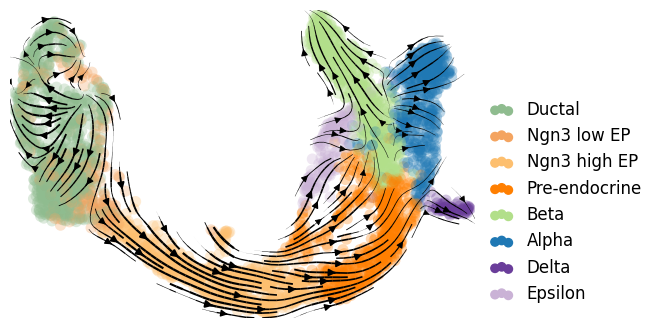

In [12]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.velocity_embedding_stream(adata, basis="umap", title="", legend_loc="lower right", ax=ax)

if SAVE_FIGURES:
    fig.savefig(FIG_DIR / DATASET / "intro_vector_field.svg", format="svg", transparent=True, bbox_inches="tight")

## CellRank pipeline

In [13]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

kernel = 0.8 * vk + 0.2 * ck

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

In [14]:
estimator = cr.estimators.GPCCA(kernel)
estimator.compute_macrostates(n_states=7, cluster_key="clusters")
estimator.set_terminal_states(TERMINAL_STATES)

GPCCA[kernel=(0.8 * VelocityKernel[n=3696] + 0.2 * ConnectivityKernel[n=3696]), initial_states=None, terminal_states=['Alpha', 'Beta', 'Delta', 'Epsilon']]

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


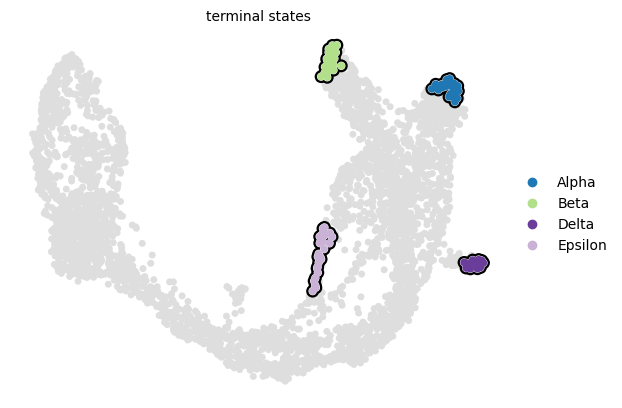

In [15]:
estimator.plot_macrostates(which="terminal", basis="umap", legend_loc="right", s=100)

## Data saving

In [16]:
if SAVE_DATA:
    adata.write_h5ad(DATA_DIR / DATASET / "processed" / "adata_run_regvelo.h5ad")
    vae.save(DATA_DIR / DATASET / "processed" / "rgv_model")